In [135]:
import sympy
import numpy as np
from scipy.linalg import eigvals
from matplotlib import pyplot as plt

sympy.init_printing()

$$ \frac{dS}{dt} = \mu - \beta S I - \mu S $$
$$ \frac{dI}{dt} = \beta S I - \gamma I - \mu I $$
$$ \frac{dR}{dt} = \gamma I - \mu R$$
        

In [136]:
t, beta, gamma, mu, S, I, R = sympy.symbols("t beta gamma mu S I R")

In [137]:
solutions = sympy.solve([
    mu - beta * S * I - mu * S,
    beta * S * I - gamma * I - mu * I,
    gamma * I - mu * R,
    sympy.Equality(S + I + R, 1)
], [S, I, R])

In [138]:
def get_endemic_equilibrium(g, m, r0):
    return [solution.subs({"gamma": g, "mu": m, "beta": R0 * (g + m)}) for solution in solutions[1]]

In [139]:
R0 = 2.5

In [140]:
endemic_eq = [solution.subs({"gamma": 1/6, "mu": 0.02/365, "beta": R0 * (1/6 + 0.02/365)}) for solution in solutions[1]]

In [141]:
jac = sympy.Matrix([
    mu - beta * S * I - mu * S,
    beta * S * I - gamma * I - mu * I,
    gamma * I - mu * R,
]).jacobian([S, I, R])

In [142]:
def get_endemic_equilibrium(g, m, r0, jac):

    solutions = sympy.solve([
        mu - beta * S * I - mu * S,
        beta * S * I - gamma * I - mu * I,
        gamma * I - mu * R,
        sympy.Equality(S + I + R, 1)
    ], [S, I, R])

    endemic_sol = [solution.subs({"gamma": g, "mu": m, "beta": r0 * (g + m)}) for solution in solutions[1]]

    substituted_jacobian = jac.subs({"S": endemic_sol[0],
                                     "I": endemic_sol[1],
                                     "R": endemic_sol[2],
                                     "gamma" : g,
                                     "mu": m,
                                     "beta": r0 * (g + m)})
    
    eigenvalues = eigvals(np.array(substituted_jacobian).astype(np.float64))


    return *endemic_sol, np.all(eigenvalues.real < 0)

In [143]:
get_endemic_equilibrium(1/6, 0.02/365, 0.2, jac=jac)

(5.00000000000000, -0.00131463628396144, -3.99868536371604, False)

In [144]:
RESOLUTION: int = 50

r0space = np.linspace(0.5, 18, RESOLUTION)
tau_space = np.linspace(1, 14, RESOLUTION)

I_results = np.zeros((RESOLUTION, RESOLUTION))
stability_mask = np.full((RESOLUTION, RESOLUTION), False, dtype=bool)

for r0idx, r0val in enumerate(r0space):
    for tauidx, tauval in enumerate(tau_space):
        _, i, _, st = get_endemic_equilibrium(1/tauval, 0.02/365, r0val, jac)
        I_results[tauidx, r0idx], stability_mask[tauidx, r0idx] = i, bool(st)

In [145]:
mmx = np.ma.masked_array(I_results, mask=np.invert(stability_mask))

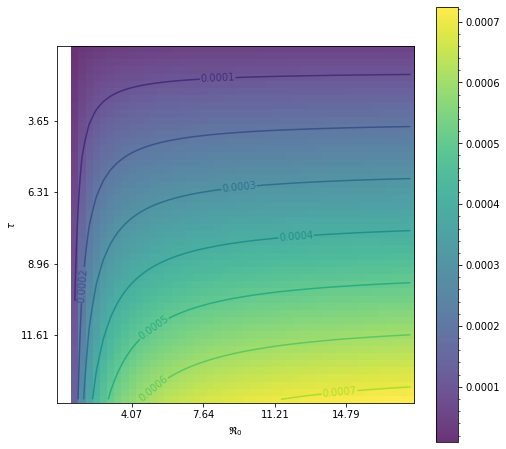

In [147]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

pos = ax.imshow(mmx, interpolation="antialiased", alpha=0.8)
ax.set_yticks([10, 20, 30, 40])
ax.set_xticks([10, 20, 30, 40])
ax.set_xticklabels(["{:.2f}".format(r0space[i]) for i in [10, 20, 30, 40]])
ax.set_yticklabels(["{:.2f}".format(tau_space[i]) for i in [10, 20, 30, 40]])
ax.set_ylabel("$\\tau$")
ax.set_xlabel("$\\mathfrak{R}_0$")
contours = ax.contour(mmx)
ax.clabel(contours, inline=True, fontsize=10)
cbar = fig.colorbar(pos)
cbar.minorticks_on()

plt.savefig("numerical_stability.pdf")